In [2]:
#cell 1 - load obt 
import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv 

# 加载本地.env文件
load_dotenv()

# 从环境变量读取连接信息
USER = os.getenv("DB_USER")
PASSWORD = os.getenv("DB_PASS")
HOST = os.getenv("DB_HOST","localhost")
PORT = os.getenv("DB_PORT","5432")
DB = os.getenv("DB_NAME")

# 检查读取是否成功(调试用)
if not PASSWORD:
    print("警告:未找到数据库密码,请检查.env文件")
else:
    print("配置加载成功(具体信息已隐藏)")

engine = create_engine(f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}")
df = pd.read_sql("SELECT * FROM analysis.analysis_orders_obt", engine)

# 基础检查
df.shape, df[['delay_days','review_score','gmv']].describe()


配置加载成功(具体信息已隐藏)


((96470, 26),
          delay_days  review_score           gmv
 count  96470.000000  96470.000000  96470.000000
 mean     -10.957013      4.126392    159.853663
 std       10.019197      1.325737    218.820405
 min     -146.000000      0.000000      0.000000
 25%      -16.000000      4.000000     61.880000
 50%      -11.000000      5.000000    105.280000
 75%       -6.000000      5.000000    176.330000
 max      188.000000      5.000000  13664.080000)

In [3]:
#cell 2 - calculate statistical fields

# 分别计算Pearson,Spearman相关系数
corr_p = df[["delay_days","review_score"]].corr(method="pearson").iloc[0,1]
corr_s = df[["delay_days","review_score"]].corr(method="spearman").iloc[0,1]
print(f"Pearson corr(delay,review) = {corr_p:.4f}")
print(f"Spearman corr(delay,review) = {corr_s:.4f}")

# 按照送达情况(准时,稍微延迟,严重延迟)进行统计
print(df.groupby("delivery_status")["review_score"].agg(["count","mean","median"]))



Pearson corr(delay,review) = -0.2611
Spearman corr(delay,review) = -0.1780
                 count      mean  median
delivery_status                         
Late_Severe       5164  1.882455     1.0
Late_Small        2662  3.726521     4.0
OnTime           88644  4.269121     5.0


In [4]:
#cell 3 - model construction
import pandas as pd
import numpy as np
import statsmodels.api as sm

# =================================
# 1.指标预处理(坏评标签,购买月份)
# =================================
# 根据评价生成差评标签指标(坏评=1,非坏评=0)
# 差评: 评分不高于2的评价
df["bad_review"] = (df["review_score"] <= 2).astype(int)
# 将购买时间按月截断
df["purchase_month"] = pd.to_datetime(df["purchase_ts"]).dt.to_period('M').astype(str)

# ==================================
# 2.特征选择
# ==================================
# 策略:保留核心数值指标 + 1个核心分类指标(支付方式)
# 去掉高纬度稀疏特征(customer_state,purchase_month)以保证收敛稳定性
features_num = ["delay_days","gmv","items_cnt","freight_value"]
features_cat = ["payment_method"]
# 旧特征指标的选择
#features = ["delay_days","gmv","items_cnt","freight_value","customer_state","payment_method","purchase_month"]

# 数据构建
model_df = df[features_num + features_cat + ["bad_review"]].dropna()

# ==================================
# 3.数据标准化(重要)
# ==================================
# 数学意义:将所有特征拉齐到同一水平(均值为0,标准差为1)
# 业务意义:系数大小直接代表"重要性",方便直接比较
for c in features_num:
    #
    model_df[c] = (model_df[c] - model_df[c].mean()) / model_df[c].std()

# ==================================
# 4.One-Hot编码和矩阵构建
# ==================================
X = pd.get_dummies(model_df[features_num + features_cat],drop_first=True)

# 清洗列名(防止statmodels报错)
X.columns = [c.replace(' ','_').replace('-','_') for c in X.columns]
X = X.astype(float)
y= model_df["bad_review"].astype(float)

# 添加截距项
X_const = sm.add_constant(X)

# ==================================
# 5.构建拟合模型(使用BFGS优化器)
# ==================================
# BFGS的选择
try:
    logit = sm.Logit(y, X_const).fit(method='bfgs', maxiter=1000)
    
    # 打印结果
    print(logit.summary().as_text()[:2000])
    
    # 计算Odds Ratio(机率比)，比看系数更直观
    print("\n========== 业务解读(Odds Ratio) ==========")
    params = logit.params
    conf = logit.conf_int()
    conf['Odds Ratio'] = params
    conf.columns = ['5%', '95%', 'Odds Ratio']
    # 取指数 np.exp() 将 Log-Odds 还原为倍数关系
    print(np.exp(conf).sort_values(by="Odds Ratio", ascending=False))
    
except Exception as e:
    print(f"Optimization failed: {e}")

Optimization terminated successfully.
         Current function value: 0.355913
         Iterations: 58
         Function evaluations: 59
         Gradient evaluations: 59
                           Logit Regression Results                           
Dep. Variable:             bad_review   No. Observations:                96470
Model:                          Logit   Df Residuals:                    96459
Method:                           MLE   Df Model:                           10
Date:                Thu, 29 Jan 2026   Pseudo R-squ.:                 0.09777
Time:                        18:43:36   Log-Likelihood:                -34335.
converged:                       True   LL-Null:                       -38056.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [6]:
#cell 6
# ==========================================
# 模型评估 (Model Evaluation)
# ==========================================
from sklearn.metrics import roc_auc_score, classification_report, roc_curve

# 1.获取预测概率
# statsmodels的predict返回的是概率值 (0到1之间)
y_pred_prob = logit.predict(X_const)

# 2.将概率转换为0/1标签 (通常以0.5为阈值)
y_pred = (y_pred_prob > 0.5).astype(int)

# 3.计算核心指标
auc_score = roc_auc_score(y,y_pred_prob)

print(f"========== 模型评估报告 ==========")
print(f"AUC Score: {auc_score:.4f} (衡量模型区分好坏评的能力)")
print("-" * 30)
print("详细分类报告 (Classification Report):")
# target_names 对应 [0:非差评, 1:差评]
print(classification_report(y, y_pred, target_names=['Not Bad', 'Bad Review']))

========== 模型评估报告 ==========
AUC Score: 0.6966 (衡量模型区分好坏评的能力)
------------------------------
详细分类报告 (Classification Report):
              precision    recall  f1-score   support

     Not Bad       0.88      0.99      0.93     83514
  Bad Review       0.68      0.09      0.16     12956

    accuracy                           0.87     96470
   macro avg       0.78      0.54      0.55     96470
weighted avg       0.85      0.87      0.83     96470



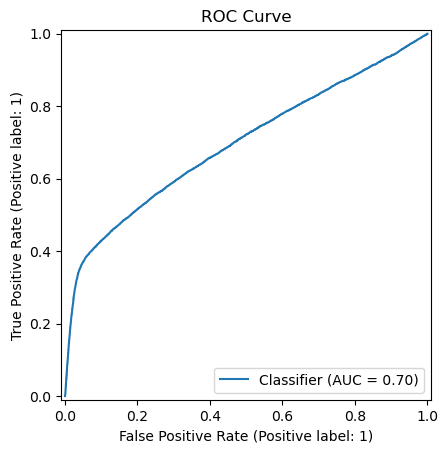

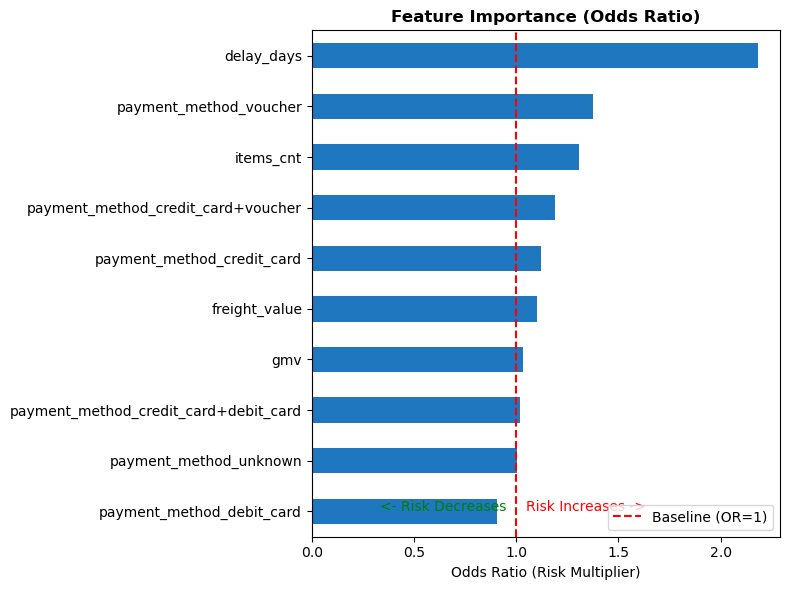

In [7]:
#cell 7 -plot

# =============================
# 1. 画出ROC曲线和AUC值
# =============================
# 逻辑:直接调用库,做到代码简单易懂
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_predictions(y,y_pred_prob)

plt.title('ROC Curve')
plt.show()

# ============================
# 2. 画出Odds Ratio图
# ============================
#plot_data = conf["Odds Ratio"].drop("const").sort_values()
#plot_data.plot(kind="barh",figsize=(8,5))
#plt.axvline(x=1,color="red",linestyle="--")
#plt.title("Feature Importance (Odds Ratio)")
#plt.show()

# logit.params是系数(Coef),np.exp(logit.params)才是OR
or_data = np.exp(logit.params).drop("const").sort_values()

fig,ax = plt.subplots(figsize=(8,6))

or_data.plot(kind="barh",color="#1f77bf",ax=ax)

# OR的基准线是1
ax.axvline(x=1,color="red",linestyle="--",linewidth=1.5,label="Baseline (OR=1)")

# 相关标注
ax.set_title('Feature Importance (Odds Ratio)', fontsize=12, fontweight='bold')
ax.set_xlabel('Odds Ratio (Risk Multiplier)')
ax.legend(loc='lower right')

# 标注解释
plt.text(1.05, 0, 'Risk Increases ->', color='red', fontsize=10)
plt.text(0.95, 0, '<- Risk Decreases', color='green', fontsize=10, ha='right')

plt.tight_layout()
plt.show()